In [1]:
import tensorflow as tf
import tensorflow.keras as keras

import tf2lib as tl
import tf2gan as gan
import DLlib as dl
import pylib as py
import wflib as wf
import data

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import tqdm
import h5py
import xlsxwriter
from skimage.metrics import structural_similarity
from itertools import cycle

In [2]:
experiment_dir = 'output/Unsup-110'
out_vars = 'R2s'
n_echoes = 4
G_model = 'U-Net'
te_input = False
ME_layer = True
fat_char = False
UQ = True
UQ_R2s = True
UQ_calib = False
n_filters = 32
batch_size = 1
D1_SelfAttention = True
D2_SelfAttention = False
D3_SelfAttention = False

In [3]:
############################################################
############### DIRECTORIES AND FILENAMES ##################
############################################################
# dataset_dir = '../MATLAB/waterFatSignalPhantom/data_out/'
dataset_dir = '../../OneDrive - Universidad Católica de Chile/Documents/MATLAB/waterFatSignalPhantom/data_out/'
dataset_hdf5_1 = 'phantom.hdf5'

############################################################
################### LOAD DATASET 1 #########################
############################################################
acqs_1, out_maps_1 = data.load_hdf5(dataset_dir,dataset_hdf5_1,MEBCRN=True)

print('Num. Elements- DS1:', len(acqs_1))

Num. Elements- DS1: 1


In [4]:
############################################################
################# DATASET PARTITIONS #######################
############################################################

testX   = acqs_1

testY   = out_maps_1

# Overall dataset statistics
len_dataset,ne,hgt,wdt,n_ch = np.shape(testX)
_,n_out,_,_,_ = np.shape(testY)
r2_sc,fm_sc = 200,300

print('Acquisition Dimensions:', hgt,wdt)
print('Echoes:',ne)
print('Output Maps:',n_out)

# Input and output dimensions (testing data)
print('Testing input shape:',testX.shape)
print('Testing output shape:',testY.shape)

A_B_dataset_test = tf.data.Dataset.from_tensor_slices((testX,testY))
A_B_dataset_test.batch(1)
test_iter = cycle(A_B_dataset_test)

Acquisition Dimensions: 192 192
Echoes: 6
Output Maps: 3
Testing input shape: (1, 6, 192, 192, 2)
Testing output shape: (1, 3, 192, 192, 2)


In [5]:
# model
if G_model == 'multi-decod' or G_model == 'encod-decod':
    if out_vars == 'WF-PM':
        G_A2B=dl.MDWF_Generator(input_shape=(hgt,wdt,d_ech),
                                te_input=te_input,
                                filters=n_filters,
                                WF_self_attention=D1_SelfAttention,
                                R2_self_attention=D2_SelfAttention,
                                FM_self_attention=D3_SelfAttention)
    else:
        G_A2B = dl.PM_Generator(input_shape=(hgt,wdt,d_ech),
                                te_input=te_input,
                                te_shape=(n_echoes,),
                                bayesian=bayesian,
                                filters=n_filters,
                                R2_self_attention=D1_SelfAttention,
                                FM_self_attention=D2_SelfAttention)

elif G_model == 'U-Net':
    if out_vars == 'WF-PM':
        n_out = 4
    elif out_vars == 'FM' or out_vars == 'R2s':
        n_out = 1
    else:
        n_out = 2
    G_A2B = dl.UNet(input_shape=(None,hgt,wdt,2),
                    n_out=n_out,
                    bayesian=UQ,
                    ME_layer=ME_layer,
                    te_input=te_input,
                    te_shape=(n_echoes,),
                    filters=n_filters,
                    self_attention=D1_SelfAttention)
    if out_vars == 'R2s':
        G_A2R2= dl.UNet(input_shape=(None,hgt,wdt,1),
                        bayesian=UQ,
                        ME_layer=ME_layer,
                        te_input=te_input,
                        te_shape=(n_echoes,),
                        filters=n_filters,
                        output_activation='sigmoid',
                        self_attention=D2_SelfAttention)
        G_calib = tf.keras.Sequential()
        G_calib.add(tf.keras.layers.Conv2D(1,1,use_bias=False,kernel_initializer='ones',kernel_constraint=tf.keras.constraints.NonNeg()))
        G_calib.build((None, 1, hgt, wdt, 1))

elif G_model == 'MEBCRN':
    if out_vars == 'WF-PM':
        n_out = 4
    else:
        n_out = 2
    G_A2B=dl.MEBCRN(input_shape=(hgt,wdt,d_ech),
                    n_outputs=n_out,
                    n_res_blocks=5,
                    n_downsamplings=2,
                    filters=n_filters,
                    self_attention=D1_SelfAttention)

else:
    raise(NameError('Unrecognized Generator Architecture'))

# restore
if out_vars == 'R2s':
    tl.Checkpoint(dict(G_A2B=G_A2B,G_A2R2=G_A2R2), py.join(experiment_dir, 'checkpoints')).restore()
else:
    tl.Checkpoint(dict(G_A2B=G_A2B), py.join(experiment_dir, 'checkpoints')).restore()

In [6]:
# Reduced-Ideal model
@tf.function
def sample(A, B, TE=None):
    # Estimate A2B
    if out_vars == 'WF':
        if te_input:
            A2B_WF_abs = G_A2B([A,TE], training=True)
        else:
            A2B_WF_abs = G_A2B(A, training=True)
        A2B_WF_abs = tf.where(A[:,:,:,:2]!=0.0,A2B_WF_abs,0.0)
        A2B_PM = tf.zeros_like(B_PM)
        # Split A2B param maps
        A2B_R2, A2B_FM = tf.dynamic_partition(A2B_PM,indx_PM,num_partitions=2)
        A2B_R2 = tf.reshape(A2B_R2,B[:,:,:,:1].shape)
        A2B_FM = tf.reshape(A2B_FM,B[:,:,:,:1].shape)
        A2B_abs = tf.concat([A2B_WF_abs,A2B_PM],axis=-1)
        A2B_var = None
    elif out_vars == 'PM':
        if te_input:
            A2B_PM = G_A2B([A,TE], training=True)
        else:
            A2B_PM = G_A2B(A, training=True)
        A2B_PM = tf.where(B_PM!=0.0,A2B_PM,0.0)
        A2B_R2, A2B_FM = tf.dynamic_partition(A2B_PM,indx_PM,num_partitions=2)
        A2B_R2 = tf.reshape(A2B_R2,B[:,:,:,:1].shape)
        A2B_FM = tf.reshape(A2B_FM,B[:,:,:,:1].shape)
        if G_model=='U-Net' or G_model=='MEBCRN':
            A2B_FM = (A2B_FM - 0.5) * 2
            A2B_FM = tf.where(B_PM[:,:,:,1:]!=0.0,A2B_FM,0.0)
            A2B_PM = tf.concat([A2B_R2,A2B_FM],axis=-1)
        A2B_WF = wf.get_rho(A,A2B_PM)
        A2B_WF_real = A2B_WF[:,:,:,0::2]
        A2B_WF_imag = A2B_WF[:,:,:,1::2]
        A2B_WF_abs = tf.abs(tf.complex(A2B_WF_real,A2B_WF_imag))
        A2B_abs = tf.concat([A2B_WF_abs,A2B_PM],axis=-1)
        A2B_var = None
    elif out_vars == 'WF-PM':
        B_abs = tf.concat([B_WF_abs,B_PM],axis=-1)
        if te_input:
            A2B_abs = G_A2B([A,TE], training=True)
        else:
            A2B_abs = G_A2B(A, training=True)
        A2B_abs = tf.where(B_abs!=0.0,A2B_abs,0.0)
        A2B_WF_abs,A2B_PM = tf.dynamic_partition(A2B_abs,indx_B_abs,num_partitions=2)
        A2B_WF_abs = tf.reshape(A2B_WF_abs,B[:,:,:,:2].shape)
        A2B_PM = tf.reshape(A2B_PM,B[:,:,:,4:].shape)
        A2B_R2, A2B_FM = tf.dynamic_partition(A2B_PM,indx_PM,num_partitions=2)
        A2B_R2 = tf.reshape(A2B_R2,B[:,:,:,:1].shape)
        A2B_FM = tf.reshape(A2B_FM,B[:,:,:,:1].shape)
        if G_model=='U-Net' or G_model=='MEBCRN':
            A2B_FM = (A2B_FM - 0.5) * 2
            A2B_FM = tf.where(B_PM[:,:,:,:1]!=0.0,A2B_FM,0.0)
            A2B_abs = tf.concat([A2B_WF_abs,A2B_R2,A2B_FM],axis=-1)
        A2B_var = None
    elif out_vars == 'FM':
        if UQ:
            _, A2B_FM, A2B_var = G_A2B(A, training=False)
        else:
            A2B_FM = G_A2B(A, training=False)
            A2B_var = None
        
        # A2B Masks
        A2B_FM = tf.where(A[:,:,:,:1]!=0.0,A2B_FM,0.0)
        if UQ:
            A2B_var = tf.where(A[:,:,:,:1]!=0.0,A2B_var,0.0)

        # Build A2B_PM array with zero-valued R2*
        A2B_PM = tf.concat([tf.zeros_like(A2B_FM),A2B_FM], axis=-1)
        if fat_char:
            A2B_P, A2B2A = fa.acq_to_acq(A,A2B_PM,complex_data=(G_model=='complex'))
            A2B_WF = A2B_P[:,:,:,0:4]
        else:
            A2B_WF, A2B2A = wf.acq_to_acq(A,A2B_PM,complex_data=(G_model=='complex'))
        A2B = tf.concat([A2B_WF,A2B_PM],axis=-1)

        # Magnitude of water/fat images
        A2B_WF_real = A2B_WF[:,:,:,0::2]
        A2B_WF_imag = A2B_WF[:,:,:,1::2]
        A2B_WF_abs = tf.abs(tf.complex(A2B_WF_real,A2B_WF_imag))
        A2B_abs = tf.concat([A2B_WF_abs,A2B_PM],axis=-1)
    elif out_vars == 'R2s':
        A_abs = tf.math.sqrt(tf.reduce_sum(tf.square(A),axis=-1,keepdims=True))
        
        # Compute R2s maps using only-mag images
        A2B_R2 = G_A2R2(A_abs, training=False) # Mean R2s
        if UQ_R2s:
            A2B_R2_nu = A2B_R2.mean()
            if UQ_calib:
                A2B_R2_sigma = G_calib(A2B_R2.stddev(), training=False)
            else:
                A2B_R2_sigma = A2B_R2.stddev()
        else:
            A2B_R2_nu = tf.zeros_like(A2B_R2)
            A2B_R2_sigma = tf.zeros_like(A2B_R2)

        # Compute FM from complex-valued images
        A2B_FM = G_A2B(A, training=False)
        if UQ:
            A2B_FM_var = A2B_FM.stddev()
        else:
            A2B_FM_var = tf.zeros_like(A2B_FM)
        A2B_PM = tf.concat([A2B_FM.mean(),A2B_R2.mean()], axis=-1)

        # Variance map mask
        if UQ:
            A2B_WF, A2B_WF_var = wf.PDFF_uncertainty(A, A2B_FM, A2B_R2, rem_R2=False)
            A2B_WF_var = tf.concat([A2B_WF_var,tf.zeros_like(A2B_WF_var)],axis=-1)
            A2B_PM_var = tf.concat([A2B_FM.variance(),A2B_R2.variance()],axis=-1)
            A2B_var = tf.concat([A2B_WF_var,A2B_PM_var], axis=1)
            A2B_var = tf.where(A[:,:3,:,:,:]!=0,A2B_var,1e-8)
        else:
            A2B_WF = wf.get_rho(A,A2B_PM)
            A2B_var = None

        A2B = tf.concat([A2B_WF,A2B_PM], axis=1)
        A2B = tf.where(A[:,:3,:,:,:]!=0,A2B,0.0)

    return A2B, A2B_var

In [7]:
A, B = next(test_iter)
A = tf.expand_dims(A,axis=0)
B = tf.expand_dims(B,axis=0)
if te_input:
    te_orig = wf.gen_TEvar(n_echoes,batch_size,orig=True)
    A2B, A2B_var = sample(A,B,TE=te_orig)
else:
    A2B, A2B_var = sample(A,B)

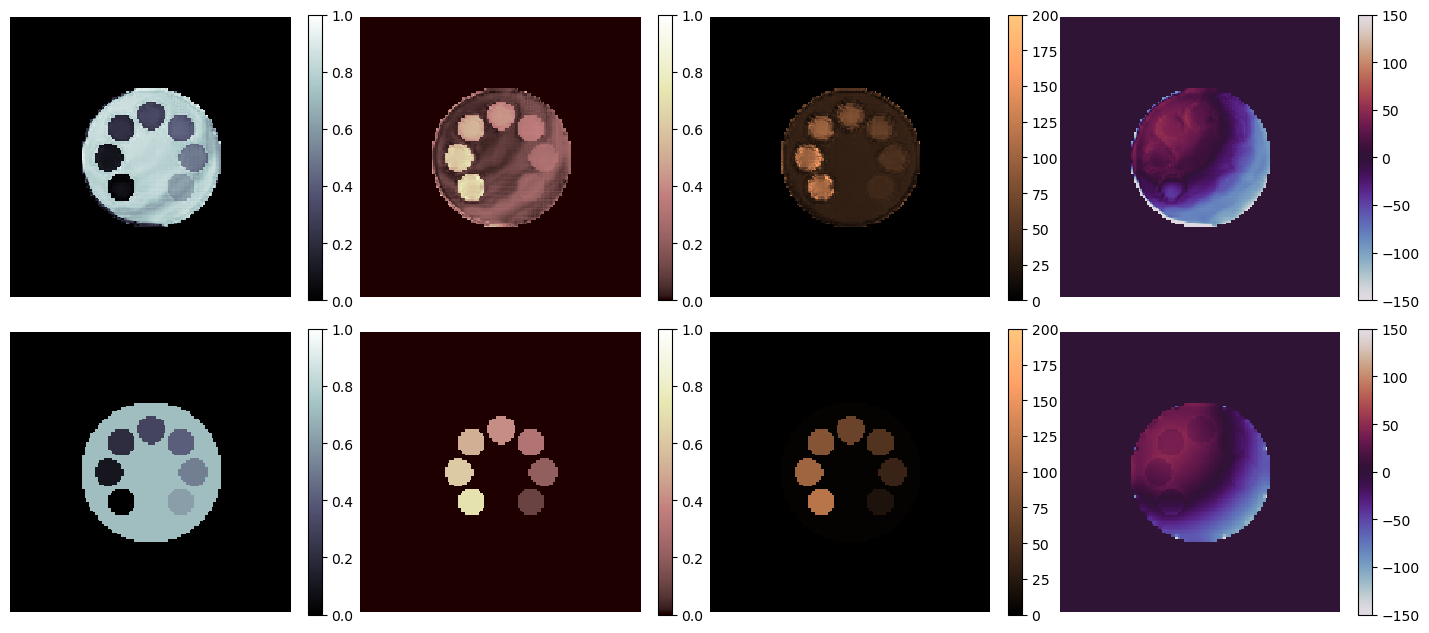

In [8]:
fig, ((ax1,ax2,ax3,ax4),(ax5,ax6,ax7,ax8))=plt.subplots(figsize=(14, 6),
                                                        nrows=2, ncols=4)
# Ground truth in the first row
w_aux = np.squeeze(tf.abs(tf.complex(A2B[:,0,:,:,0],A2B[:,0,:,:,1])))
W_ok = ax1.imshow(w_aux, cmap='bone',
                  interpolation='none', vmin=0, vmax=1)
fig.colorbar(W_ok, ax=ax1)
ax1.axis('off')

f_aux = np.squeeze(tf.abs(tf.complex(A2B[:,1,:,:,0],A2B[:,1,:,:,1])))
F_ok = ax2.imshow(f_aux, cmap='pink',
                  interpolation='none', vmin=0, vmax=1)
fig.colorbar(F_ok, ax=ax2)
ax2.axis('off')

r2_aux = np.squeeze(A2B[:,2,:,:,1])*r2_sc
r2_ok = ax3.imshow(r2_aux, cmap='copper',
                   interpolation='none', vmin=0, vmax=r2_sc)
fig.colorbar(r2_ok, ax=ax3)
ax3.axis('off')

field_aux = np.squeeze(A2B[:,2,:,:,0])*fm_sc
field_ok = ax4.imshow(field_aux, cmap='twilight',
                      interpolation='none', vmin=-fm_sc/2, vmax=fm_sc/2)
fig.colorbar(field_ok, ax=ax4)
ax4.axis('off')

# Computed maps in the second row
wn_aux = np.squeeze(np.abs(tf.complex(B[:,0,:,:,0],B[:,0,:,:,1])))
W_unet = ax5.imshow(wn_aux, cmap='bone',
                    interpolation='none', vmin=0, vmax=1)
fig.colorbar(W_unet, ax=ax5)
ax5.axis('off')

fn_aux = np.squeeze(np.abs(tf.complex(B[:,1,:,:,0],B[:,1,:,:,1])))
F_unet = ax6.imshow(fn_aux, cmap='pink',
                    interpolation='none', vmin=0, vmax=1)
fig.colorbar(F_unet, ax=ax6)
ax6.axis('off')

r2n_aux = np.squeeze(B[:,2,:,:,1]) * r2_sc
r2_unet = ax7.imshow(r2n_aux, cmap='copper',
                     interpolation='none', vmin=0, vmax=r2_sc)
fig.colorbar(r2_unet, ax=ax7)
ax7.axis('off')

fieldn_aux = np.squeeze(B[:,2,:,:,0]) * fm_sc
field_unet = ax8.imshow(fieldn_aux, cmap='twilight',
                        interpolation='none', vmin=-fm_sc/2, vmax=fm_sc/2)
fig.colorbar(field_unet, ax=ax8)
ax8.axis('off')

plt.subplots_adjust(top=1,bottom=0,right=1,left=0,hspace=0.1,wspace=0)
plt.show()

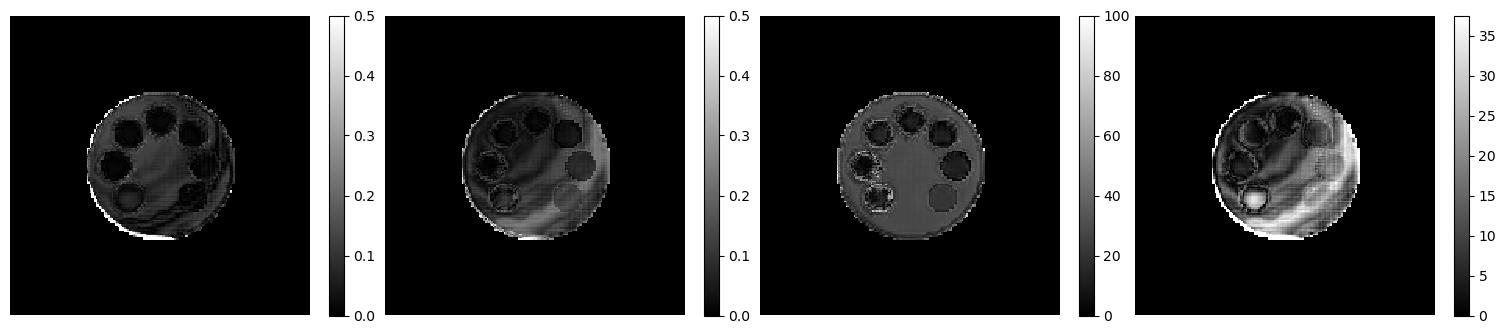

In [38]:
# DISPLAY ERROR (4 OUTPUTS)
fig_err, (ix1,ix2,ix3,ix4) = plt.subplots(figsize=(15, 3), nrows=1, ncols=4)

# Ground truth in the first row
w_err = np.abs(w_aux-wn_aux)
Wn_err = ix1.imshow(w_err, cmap='gray',
                    interpolation='none', vmin=0, vmax=0.5)
fig_err.colorbar(Wn_err, ax=ix1)
# ix1.set_title('Water Error')
ix1.axis('off')
f_err = np.abs(f_aux-fn_aux)
Fn_err = ix2.imshow(f_err, cmap='gray',
                    interpolation='none', vmin=0, vmax=0.5)
fig_err.colorbar(Fn_err, ax=ix2)
# ix2.set_title('Fat Error')
ix2.axis('off')
r2_err = np.abs(r2_aux-r2n_aux)
r2n_err = ix3.imshow(r2_err, cmap='gray',
                     interpolation='none', vmin=0, vmax=r2_sc/2)
fig_err.colorbar(r2n_err, ax=ix3)
# ix3.set_title('R2* Error')
ix3.axis('off')
field_err = np.abs(field_aux-fieldn_aux)
fieldn_err = ix4.imshow(field_err, cmap='gray',
                        interpolation='none', vmin=0, vmax=fm_sc/8)
fig_err.colorbar(fieldn_err, ax=ix4)
# ix4.set_title('Field Error')
ix4.axis('off')

plt.subplots_adjust(top=1,bottom=0,right=1,left=0,hspace=0.1,wspace=0)
plt.show()

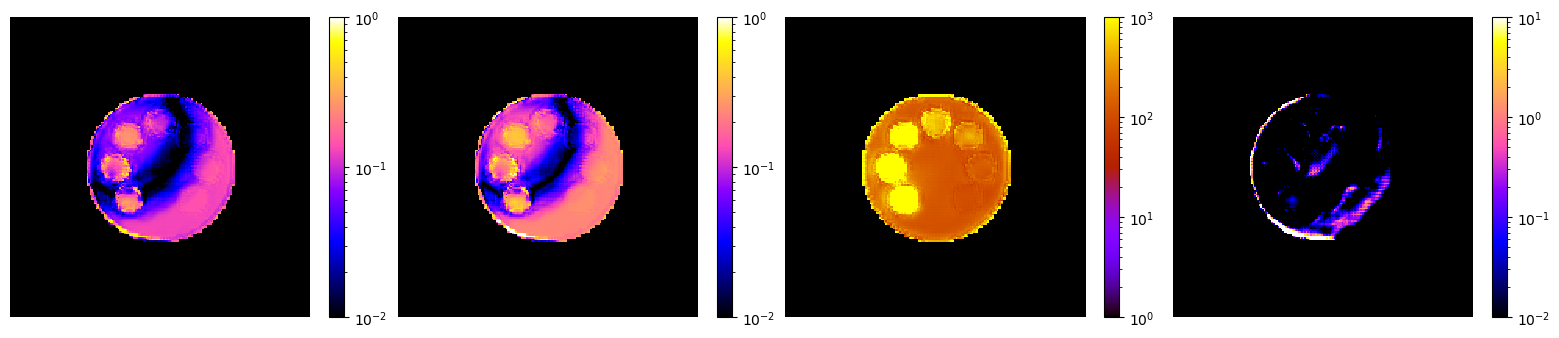

In [10]:
from matplotlib.colors import LogNorm

if UQ: #bayesian
    # DISPLAY STD (4 OUTPUTS)
    fig_std, oxs = plt.subplots(figsize=(15.5, 3), nrows=1, ncols=4)

    W_var = np.squeeze(tf.abs(tf.complex(A2B_var[:,0,:,:,0],A2B_var[:,0,:,:,1])))
    W_uq = oxs[0].matshow(W_var, cmap='gnuplot2', norm=LogNorm(vmin=1e-2,vmax=1e0))
    fig_std.colorbar(W_uq, ax=oxs[0])
    oxs[0].axis('off')
    
    F_var = np.squeeze(tf.abs(tf.complex(A2B_var[:,1,:,:,0],A2B_var[:,1,:,:,1])))
    F_uq = oxs[1].matshow(F_var, cmap='gnuplot2', norm=LogNorm(vmin=1e-2,vmax=1e0))
    fig_std.colorbar(F_uq, ax=oxs[1])
    oxs[1].axis('off')

    # STDs in the two subplots
    r2s_var = np.squeeze(A2B_var[:,2,:,:,1])*(r2_sc**2)
    r2s_uq = oxs[2].matshow(r2s_var, cmap='gnuplot', norm=LogNorm(vmin=1e0,vmax=1e3))
    fig_std.colorbar(r2s_uq, ax=oxs[2])
    oxs[2].axis('off')
    field_var = np.squeeze(A2B_var[:,2,:,:,0])*(fm_sc**2)
    field_uq = oxs[3].matshow(field_var, cmap='gnuplot2', norm=LogNorm(vmin=1e-2,vmax=1e1))
    fig_std.colorbar(field_uq, ax=oxs[3])
    oxs[3].axis('off')

    plt.subplots_adjust(top=1,bottom=0,right=1,left=0,hspace=0.1,wspace=0)
    plt.show()

In [11]:
MAE_w = np.mean(tf.abs(w_aux-wn_aux), axis=(0,1))
MAE_f = np.mean(tf.abs(f_aux-fn_aux), axis=(0,1))
MAE_r2 = np.mean(tf.abs(r2_aux-r2n_aux), axis=(0,1))
MAE_fm = np.mean(tf.abs(field_aux-fieldn_aux), axis=(0,1))
print('MAEs:',np.round([MAE_w,MAE_f,MAE_r2,MAE_fm],5))
print('R2* MAE [1/s]:',np.round(200*MAE_r2,5))
print('Field Map MAE [Hz]:',np.round(300*MAE_fm,5))

MAEs: [0.01636 0.01998 4.98118 3.28299]
R2* MAE [1/s]: 996.23671
Field Map MAE [Hz]: 984.89821


In [12]:
w_ssim = structural_similarity(w_aux,wn_aux,multichannel=False)
f_ssim = structural_similarity(f_aux,fn_aux,multichannel=False)
r2_ssim = structural_similarity(r2_aux,r2n_aux,multichannel=False)
fm_ssim = structural_similarity(field_aux,fieldn_aux,multichannel=False)
print('SSIMs:',np.round([w_ssim,f_ssim,r2_ssim,fm_ssim],5))

SSIMs: [0.9611  0.84553 0.79853 0.86621]


C:\Users\jpmen\AppData\Local\Temp\ipykernel_8352\912484574.py:1: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  w_ssim = structural_similarity(w_aux,wn_aux,multichannel=False)
C:\Users\jpmen\AppData\Local\Temp\ipykernel_8352\912484574.py:2: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  f_ssim = structural_similarity(f_aux,fn_aux,multichannel=False)
C:\Users\jpmen\AppData\Local\Temp\ipykernel_8352\912484574.py:3: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  r2_ssim = structural_similarity(r2_aux,r2n_aux,multichannel=False)
C:\Users\jpmen\AppData\Local\Temp\ipykernel_8352\912484574.py:4: FutureWarning: `multichannel` is a deprecated argument name fo

C:\Users\jpmen\AppData\Local\Temp\ipykernel_8352\728761560.py:2: RuntimeWarning: invalid value encountered in true_divide
  PDFF_res = f_aux/(w_aux+f_aux)
C:\Users\jpmen\AppData\Local\Temp\ipykernel_8352\728761560.py:6: RuntimeWarning: invalid value encountered in true_divide
  PDFF_gt = fn_aux/(wn_aux+fn_aux)


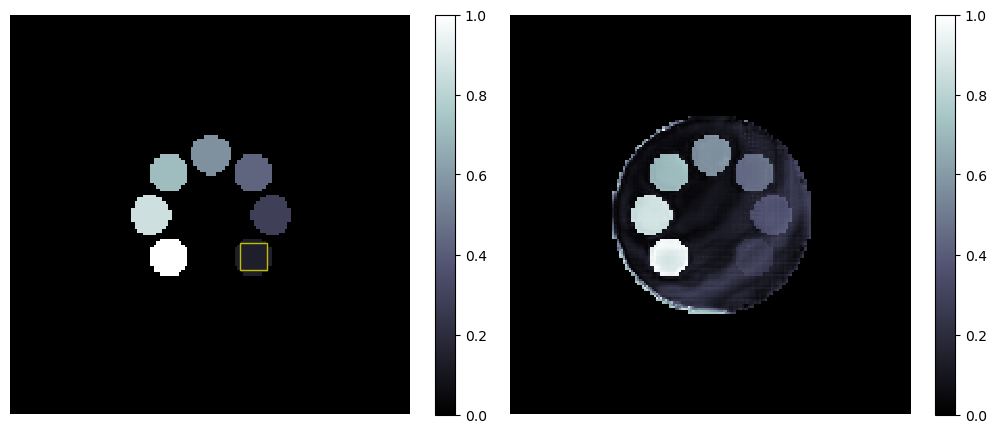

In [13]:
# Ground-Truth PDFF
PDFF_res = f_aux/(w_aux+f_aux)
PDFF_res[np.isnan(PDFF_res)] = 0.0

# Model Measured PDFF
PDFF_gt = fn_aux/(wn_aux+fn_aux)
PDFF_gt[np.isnan(PDFF_gt)] = 0.0

# Segmentation rectangle (ref. values for test data N°105)
verts_list = {1:   (69,109),#ok
              2:   (61,89),#ok
              3:   (69,68),#ok
              4:   (90,60),#ok
              5:  (110,68),#ok
              6:  (119,89),#ok
              7:  (110,109)}#ok

left_x,sup_y = verts_list[7]
rect_hgt,rect_wdt = 13,13
rect_gt = patches.Rectangle((left_x,sup_y),rect_wdt,rect_hgt,
                            linewidth=1,edgecolor='y',facecolor='none')
rect_res = patches.Rectangle((left_x,sup_y),rect_wdt,rect_hgt,
                             linewidth=1,edgecolor='r',facecolor='none')

fig_pdff, (ex1,ex2) = plt.subplots(figsize=(10, 4), nrows=1, ncols=2)

disp_pdff_ok = ex1.imshow(PDFF_gt, cmap='bone',
                          interpolation='none', vmin=0, vmax=1)
fig_pdff.colorbar(disp_pdff_ok, ax=ex1)
# ex1.set_title('PDFF Ground Truth',{'fontsize':15})
ex1.add_patch(rect_gt)
ex1.axis('off')

disp_pdff_res = ex2.imshow(PDFF_res, cmap='bone',
                           interpolation='none', vmin=0, vmax=1)
fig_pdff.colorbar(disp_pdff_res, ax=ex2)
# ex2.set_title('Resulting PDFF',{'fontsize':15})
# ex2.add_patch(rect_res)
ex2.axis('off')

plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
                    hspace = 0.1, wspace = 0)
plt.margins(0,0)
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())

In [14]:
r1,r2 = sup_y,(sup_y+rect_hgt)
c1,c2 = left_x,(left_x+rect_wdt)
PDFF_gt_crop = PDFF_gt[r1:r2,c1:c2]
PDFF_res_crop = PDFF_res[r1:r2,c1:c2]

print('Median of PDFF in the segmented region:')
print('Ground-Truth:\t',np.median(PDFF_gt_crop))
print('Model result:\t',np.median(PDFF_res_crop))

Median of PDFF in the segmented region:
Ground-Truth:	 0.14285715
Model result:	 0.27471998


In [33]:
PDFF_res_all = list()
PDFF_gt_all = list()
rect_hgt,rect_wdt = 13,13
for k in verts_list:
    left_x,sup_y = verts_list[k]
    r1,r2 = sup_y,(sup_y+rect_hgt)
    c1,c2 = left_x,(left_x+rect_wdt)
    # PDFF crops - magnitude model results
    # w_all = all_test_ans[(k_prev+4):(k-4),r1:r2,c1:c2,0]
    # f_all = all_test_ans[(k_prev+4):(k-4),r1:r2,c1:c2,1]
    # PDFF crops - complex model results
    w_all = w_aux[r1:r2,c1:c2]
    f_all = f_aux[r1:r2,c1:c2]
    PDFF_res_aux = np.median(f_all/(f_all+w_all))
    PDFF_res_all.append(PDFF_res_aux)
    # PDFF crops - GT magnitude results
    # w_all_gt = testY[(k_prev+4):(k-4):,r1:r2,c1:c2,0]
    # f_all_gt = testY[(k_prev+4):(k-4),r1:r2,c1:c2,1]
    # PDFF crops - GT complex results
    w_all_gt = wn_aux[r1:r2,c1:c2]
    f_all_gt = fn_aux[r1:r2,c1:c2]
    PDFF_gt_aux = np.median(f_all_gt/(f_all_gt+w_all_gt))
    PDFF_gt_all.append(PDFF_gt_aux)

# Compute error
PDFF_err_list = np.array(PDFF_res_all)-np.array(PDFF_gt_all)
print('PDFF estimations:',np.round(PDFF_res_all,5))
print('Ground-truth:',np.round(PDFF_gt_all,5))
print('Errors:',np.round(PDFF_err_list,5))

# PDFF crops mean error
PDFF_err_mean = np.mean((PDFF_err_list))
PDFF_err_std = np.std((PDFF_err_list))
print('Mean PDFF error:',np.round(PDFF_err_mean*100,2),
      '+-',np.round(PDFF_err_std*100,2),'%')

PDFF estimations: [0.92276 0.86824 0.70535 0.57194 0.45324 0.3667  0.27472]
Ground-truth: [1.      0.85714 0.71429 0.57143 0.42857 0.28571 0.14286]
Errors: [-0.07724  0.0111  -0.00894  0.00052  0.02467  0.08099  0.13186]
Mean PDFF error: 2.33 +- 6.2 %


In [37]:
r2_res_all = list()
r2_gt_all = list()
for k in verts_list:
    left_x,sup_y = verts_list[k]
    r1,r2 = sup_y,(sup_y+rect_hgt)
    c1,c2 = left_x,(left_x+rect_wdt)
    # R2* crops - complex model results
    r2_all = r2_aux[r1:r2,c1:c2]
    r2_res_aux = np.mean(r2_all)
    r2_res_all.append(r2_res_aux)
    # R2* crops - GT complex results
    r2_all_gt = r2n_aux[r1:r2,c1:c2]
    r2_gt_aux = np.mean(r2_all_gt)
    r2_gt_all.append(r2_gt_aux)

# Compute error
r2_err_list = np.array(r2_res_all)-np.array(r2_gt_all)
print('R2* estimations:',r2_res_all)
print('Ground-truth:',r2_gt_all)
print('Errors:\\n',r2_err_list)

# R2* crops mean error
r2_err_mean = np.mean((r2_err_list))
r2_err_std = np.std((r2_err_list))
print('Mean R2* error:',np.round(r2_err_mean,2),
      '+-',np.round(r2_err_std,2),'[1/s]')

R2* estimations: [103.48947, 103.77, 86.44003, 69.9371, 57.23664, 47.0717, 40.51825]
Ground-truth: [116.294266, 100.73673, 83.053375, 68.655464, 50.875473, 35.801132, 19.470604]
Errors:\n [-12.804794    3.0332642   3.3866577   1.2816391   6.361168   11.270569
  21.047646 ]
Mean R2* error: 4.8 +- 9.53 [1/s]
